In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


In [3]:
train = pd.read_csv("/content/drive/MyDrive/birdspecies/training_set.csv")
labels = pd.read_csv("/content/drive/MyDrive/birdspecies/training_target.csv")

train = train.merge(labels, on="ID")

test = pd.read_csv("/content/drive/MyDrive/birdspecies/test_set.csv")

In [4]:
train.head()

,bill_depth,bill_length,wing_length,location,mass,sex,ID,species
0,14.300000,48.200000,210.000000,loc_2,4600.0,0.0,284,C
1,14.400000,48.400000,203.000000,loc_2,4625.0,0.0,101,C
2,18.400000,NaN,200.000000,loc_3,3400.0,0.0,400,B
3,14.982114,47.504878,NaN,NaN,4800.0,0.0,98,C
4,18.982114,38.259307,217.186992,loc_3,5200.0,0.0,103,C


In [5]:
target_cols = "species"
num_cols = ["bill_depth", "bill_length", "wing_length", "mass"]
cat_cols = ["location", "sex"]
all_cols = num_cols + cat_cols + [target_cols]

train = train[all_cols]

In [6]:
print("Train Shape:", train.shape)
print(train.info())


Train Shape: (435, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bill_depth   434 non-null    float64
 1   bill_length  295 non-null    float64
 2   wing_length  298 non-null    float64
 3   mass         433 non-null    float64
 4   location     405 non-null    object 
 5   sex          379 non-null    float64
 6   species      435 non-null    object 
dtypes: float64(5), object(2)
memory usage: 23.9+ KB
None


In [7]:
num_cols = ["bill_depth", "bill_length", "wing_length", "mass"]
train[num_cols].describe()


,bill_depth,bill_length,wing_length,mass
count,434.000000,295.000000,298.000000,433.000000
mean,17.295551,46.168221,202.759399,4290.877598
std,1.944587,5.056940,13.304036,793.306367
min,13.100000,38.259307,172.000000,2700.000000
25%,15.225000,43.500000,193.000000,3675.000000
50%,17.600000,47.500000,199.000000,4200.000000
75%,18.982114,48.833824,215.000000,4875.000000
max,21.500000,59.600000,231.000000,6300.000000


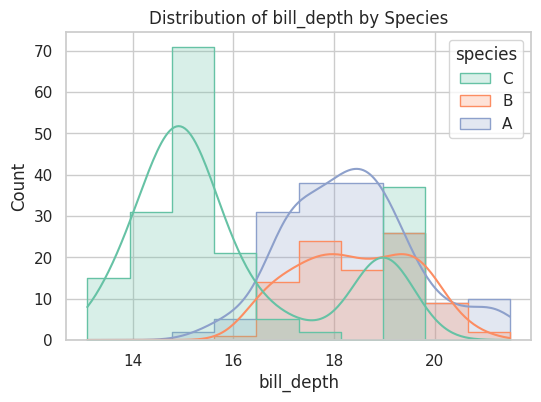

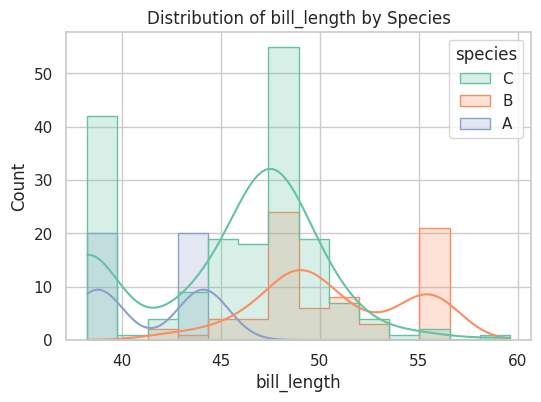

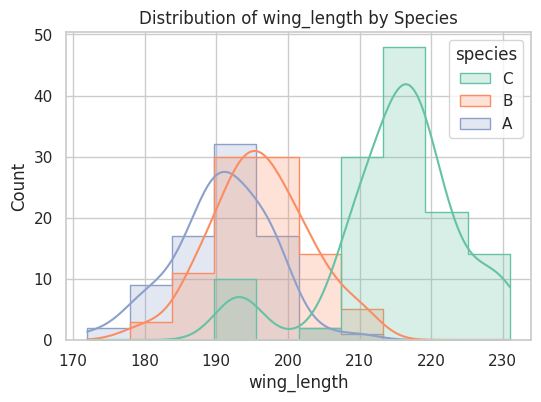

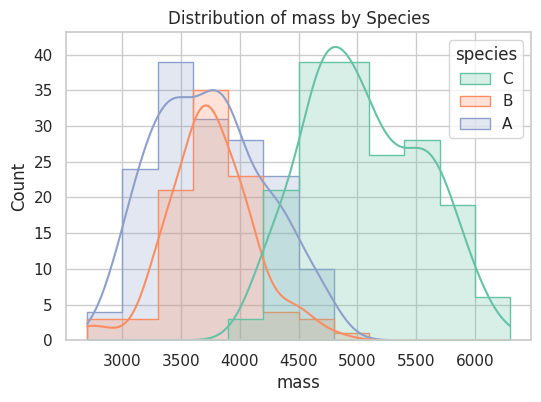

In [8]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=train, x=col, kde=True, hue="species", palette="Set2", element="step")
    plt.title(f"Distribution of {col} by Species")
    plt.show()


/tmp/ipython-input-2009560307.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = col_name, data = train, palette="Set2", ax=axes[i % 3])
/tmp/ipython-input-2009560307.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = col_name, data = train, palette="Set2", ax=axes[i % 3])
/tmp/ipython-input-2009560307.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = col_name, data = train, palette="Set2", ax=axes[i % 3])


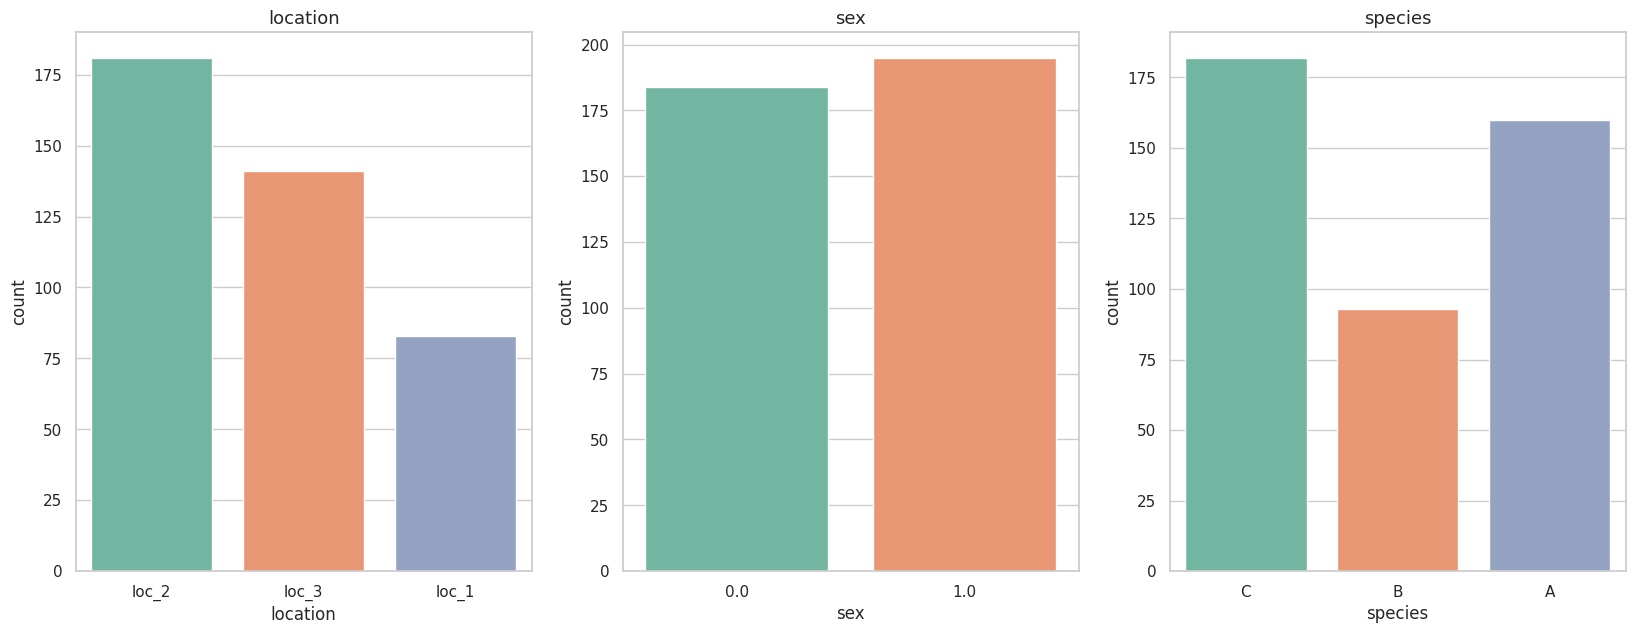

In [9]:
to_plot = cat_cols + [target_cols]
fig, axes = plt.subplots(1, 3, figsize=(20, 7), dpi=100)

for i, col_name in enumerate(train[to_plot].columns):
    sns.countplot(x = col_name, data = train, palette="Set2", ax=axes[i % 3])
    axes[i % 3].set_title(f"{col_name}", fontsize=13)
    plt.subplots_adjust(hspace=0.45)

In [10]:
train.species.value_counts()

,count
species,
C,182
A,160
B,93


 the target variable is imbalanced, where class B is almost 100 class lower than C, and around 70 lower than A.

Imbalanced class is an issue because it biases the model to place more importance on classes with more samples ie. C is predicted a lot more often than B.

In [11]:
print("\nMissing Values:\n", train.isnull().sum())




Missing Values:
 bill_depth       1
bill_length    140
wing_length    137
mass             2
location        30
sex             56
species          0
dtype: int64


In [12]:
missing = train.isnull().mean() * 100
missing = missing[missing > 0].round(2)
print("Missing Value Percentage (%):\n", missing)


Missing Value Percentage (%):
 bill_depth      0.23
bill_length    32.18
wing_length    31.49
mass            0.46
location        6.90
sex            12.87
dtype: float64


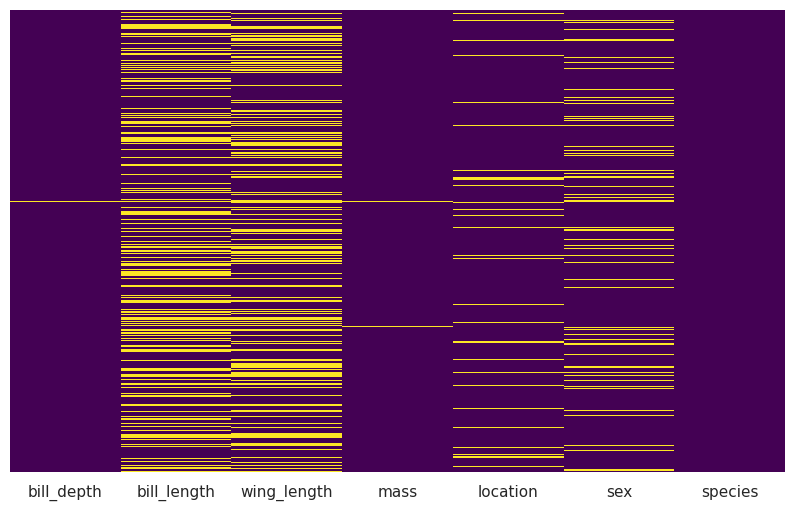

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), yticklabels=False, cmap='viridis', cbar=False);

In [14]:
cat_cols = ["location", "sex"]
missing_cat = train[cat_cols].isnull().sum()
print("Missing values in categorical variables:\n")
print(missing_cat)


Missing values in categorical variables:

location    30
sex         56
dtype: int64


In [15]:
from sklearn.impute import SimpleImputer
cat_cols = ["location", "sex"]
cat_imputer = SimpleImputer(strategy="most_frequent")
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])


In [16]:

simple_num_cols = ["bill_depth", "mass"]
median_imputer = SimpleImputer(strategy="median")
train[simple_num_cols] = median_imputer.fit_transform(train[simple_num_cols])

In [17]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
train[["bill_length", "wing_length"]] = knn_imputer.fit_transform(train[["bill_length", "wing_length"]])


In [18]:
train.isnull().sum()

,0
bill_depth,0
bill_length,0
wing_length,0
mass,0
location,0
sex,0
species,0


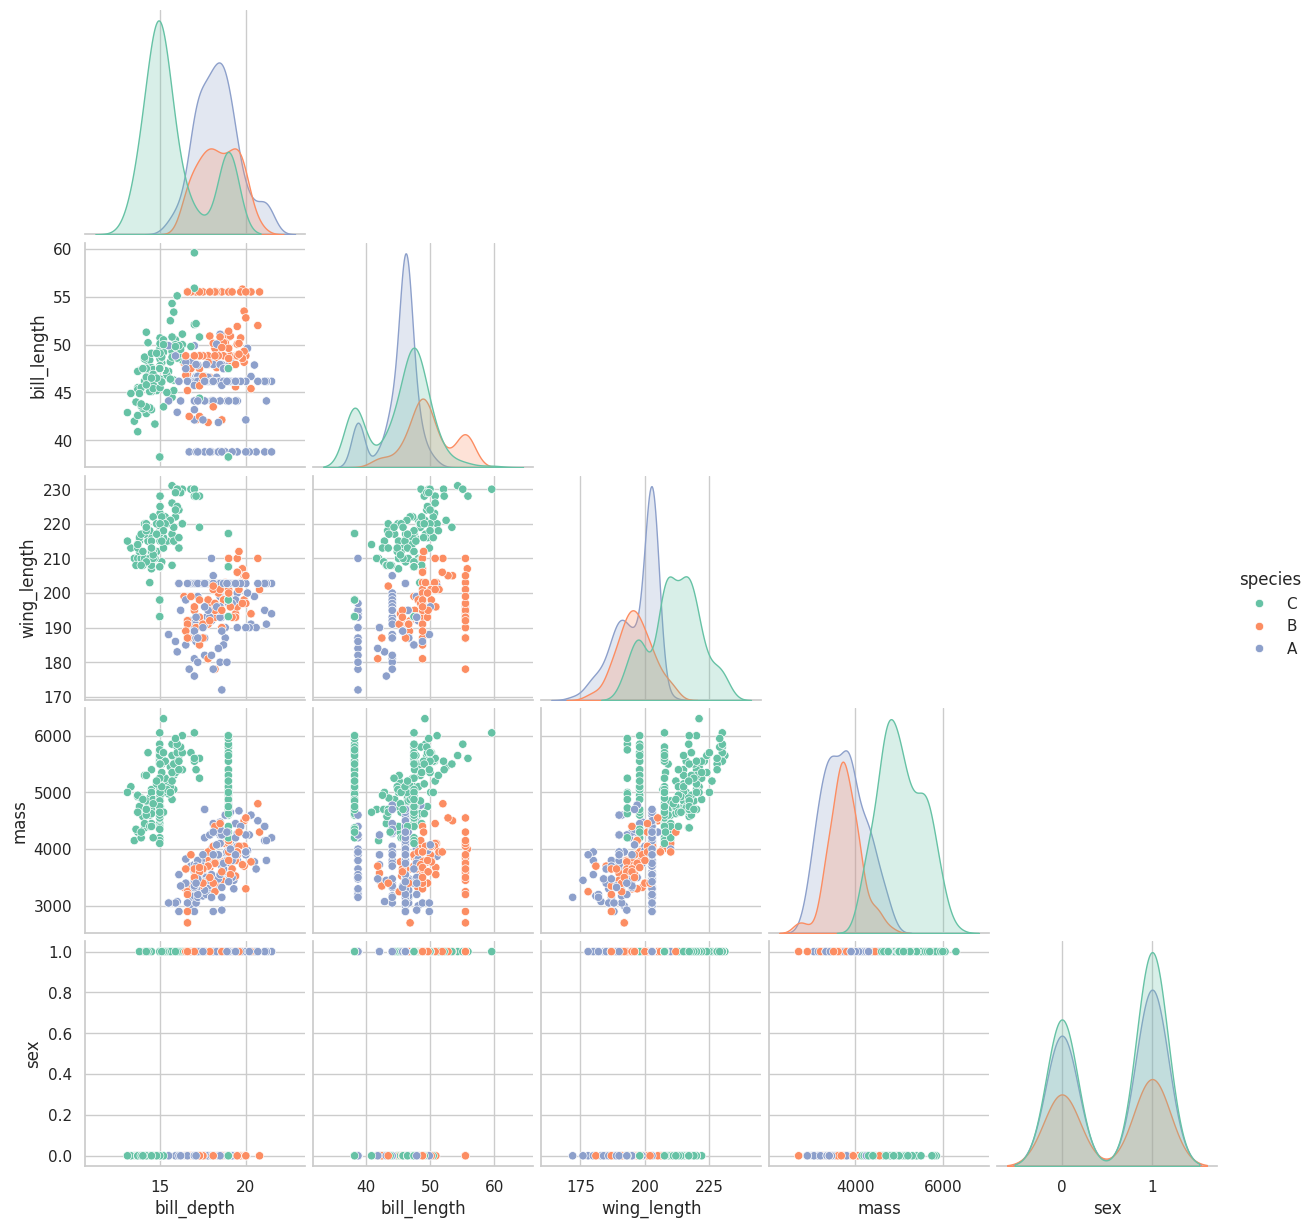

In [19]:
import seaborn as sns
sns.pairplot(train, hue="species", corner=True, palette="Set2")


In [20]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
le = LabelEncoder()
train['species'] = le.fit_transform(train['species'])
train = pd.get_dummies(train, columns=["location", "sex"], drop_first=True)


In [21]:
train.dtypes

,0
bill_depth,float64
bill_length,float64
wing_length,float64
mass,float64
species,int64
location_loc_2,bool
location_loc_3,bool
sex_1.0,bool


In [22]:
bool_cols = train.select_dtypes(include='bool').columns
train[bool_cols] = train[bool_cols].astype(int)


In [23]:
import numpy as np
train['b_depth_length_ratio'] = train['bill_depth'] / train['bill_length']
train['b_length_depth_ratio'] = train['bill_length'] / train['bill_depth']
train['w_length_mass_ratio'] = train['wing_length'] / train['mass']
train['wing_bill_ratio'] = train['wing_length'] / (train['bill_length'] + train['bill_depth'])




In [24]:
train.head(10)

,bill_depth,bill_length,wing_length,mass,species,location_loc_2,location_loc_3,sex_1.0,b_depth_length_ratio,b_length_depth_ratio,w_length_mass_ratio,wing_bill_ratio
0,14.300000,48.200000,210.000000,4600.0,2,1,0,0,0.296680,3.370629,0.045652,3.360000
1,14.400000,48.400000,203.000000,4625.0,2,1,0,0,0.297521,3.361111,0.043892,3.232484
2,18.400000,49.618979,200.000000,3400.0,1,0,1,0,0.370826,2.696684,0.058824,2.940356
3,14.982114,47.504878,207.586992,4800.0,2,1,0,0,0.315381,3.170773,0.043247,3.322083
4,18.982114,38.259307,217.186992,5200.0,2,0,1,0,0.496144,2.015545,0.041767,3.794228
5,15.000000,49.600000,216.000000,4750.0,2,1,0,1,0.302419,3.306667,0.045474,3.343653
6,18.200000,48.553617,197.000000,3750.0,1,0,1,1,0.374843,2.667781,0.052533,2.951151
7,14.800000,45.200000,212.000000,5200.0,2,1,0,0,0.327434,3.054054,0.040769,3.533333
8,18.982114,38.259307,197.986992,5400.0,2,0,0,0,0.496144,2.015545,0.036664,3.458806
9,18.500000,47.869747,199.000000,4475.0,0,0,1,1,0.386465,2.587554,0.044469,2.998354


In [25]:
from sklearn.model_selection import train_test_split
low_importance_features = [
    'b_length_depth_ratio',
    'b_depth_length_ratio',
   'wing_bill_ratio',
    'w_length_mass_ratio'
]

train = train.drop(columns=low_importance_features)


In [26]:
from sklearn.model_selection import train_test_split

X = train.drop("species", axis=1)
y = train["species"]

X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

NUM_CLASSES = train['species'].nunique()

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=NUM_CLASSES,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc_ovr_weighted',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:40:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_resampled, y_resampled)
print("Best Parameters:", random_search.best_params_)

best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_resampled)





Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.5}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:52:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [38]:
from xgboost import XGBClassifier
import numpy as np
final_xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_resampled)),
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    subsample=0.6,
    n_estimators=50,
    max_depth=7,
    learning_rate=0.2,
    gamma=0,
    colsample_bytree=0.5
)

final_xgb.fit(X_resampled, y_resampled)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:59:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, num_class=3, ...)

In [39]:
from sklearn.metrics import classification_report
y_pred = final_xgb.predict(X_resampled)

print("\nClassification Report on Resampled Data:\n")
print(classification_report(y_resampled, y_pred))





Classification Report on Resampled Data:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       182
           1       0.99      1.00      1.00       182
           2       1.00      1.00      1.00       182

    accuracy                           1.00       546
   macro avg       1.00      1.00      1.00       546
weighted avg       1.00      1.00      1.00       546



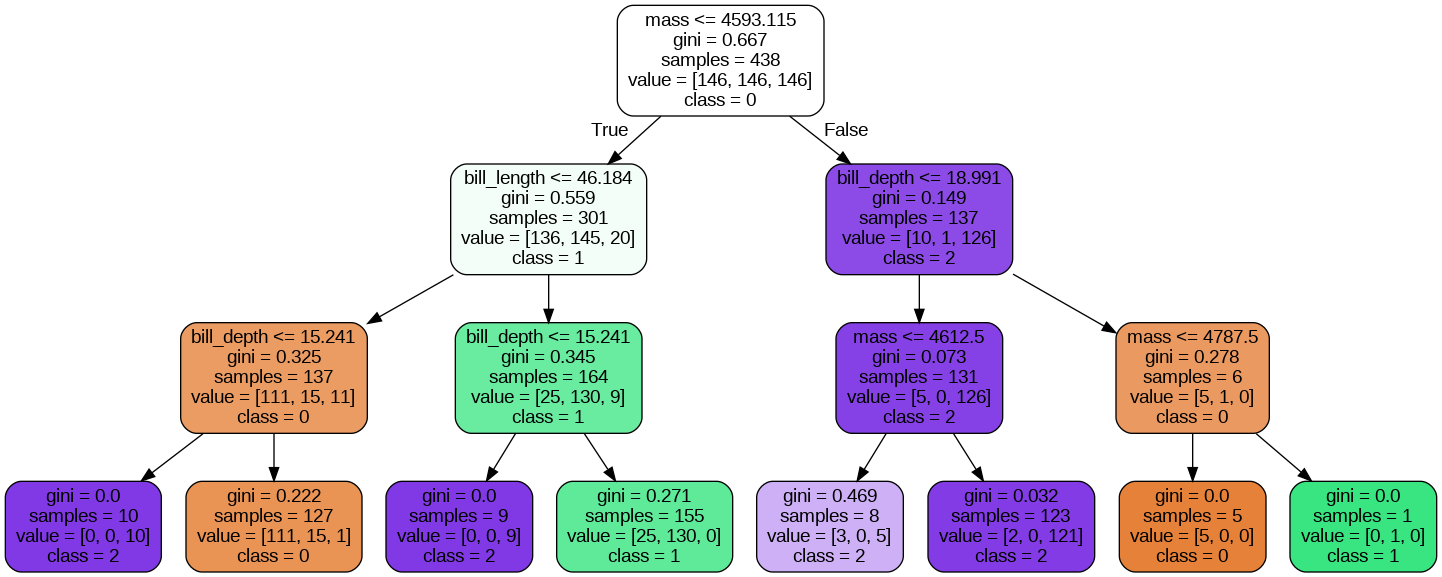

In [33]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from imblearn.over_sampling import SMOTE
from IPython.display import Image, display
import graphviz
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)


model = DecisionTreeClassifier(max_depth=3, random_state=42).fit(X_res, y_res)
dot = export_graphviz(model, out_file=None, feature_names=X.columns,
                      class_names=model.classes_.astype(str), filled=True, rounded=True)
graphviz.Source(dot, format="png").render("tree_output", cleanup=True)
display(Image("tree_output.png"))


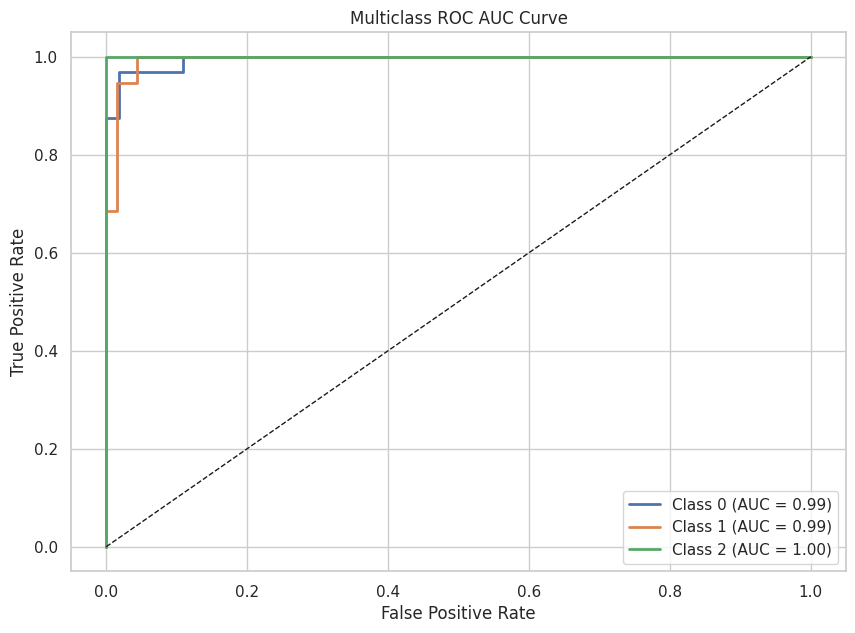

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_true_bin = label_binarize(y_eval, classes=model.classes_)
n_classes = y_true_bin.shape[1]

y_probs = model.predict_proba(X_eval)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC AUC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:01:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-821049996.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_eval, plot_type="bar")


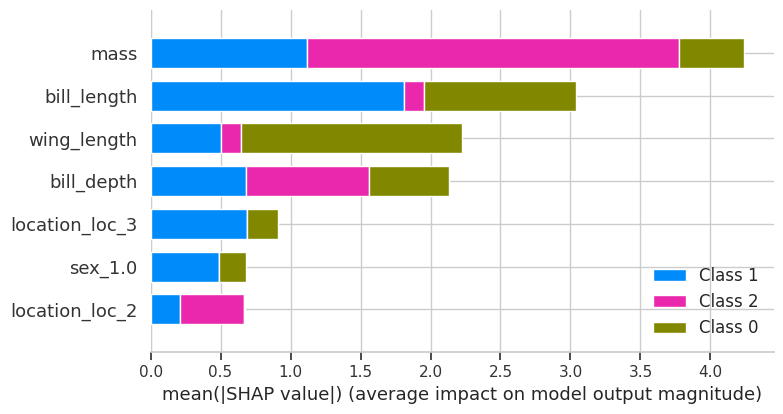

/tmp/ipython-input-821049996.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_eval)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:743: FutureWa

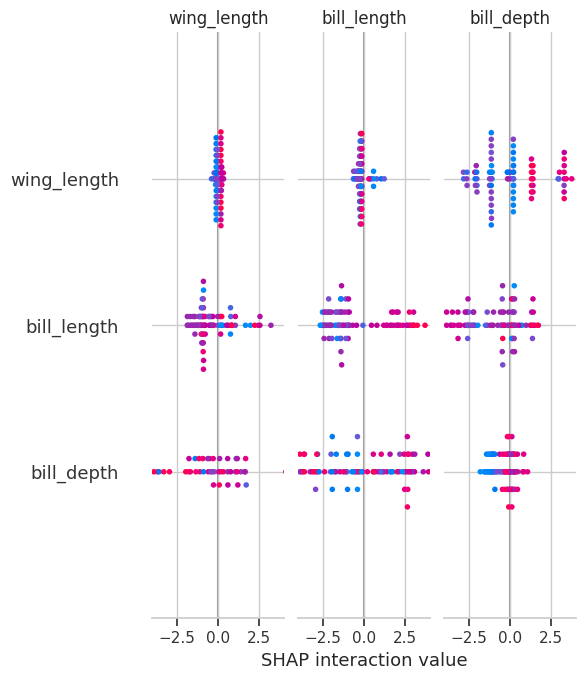

In [40]:
from sklearn.model_selection import train_test_split

X = train.drop("species", axis=1)
y = train["species"]

X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_eval)

shap.summary_plot(shap_values, X_eval, plot_type="bar")
shap.summary_plot(shap_values, X_eval)

In [44]:
train['species_original'] = le.inverse_transform(train['species'])
print(train[['species', 'species_original']].head(10))



   species species_original
0        2                C
1        2                C
2        1                B
3        2                C
4        2                C
5        2                C
6        1                B
7        2                C
8        2                C
9        0                A


In [ ]:

test = pd.read_csv("/content/drive/MyDrive/birdspecies/test_set.csv")
test_id = test["ID"]
num_cols = ["bill_depth", "bill_length", "wing_length", "mass"]
cat_cols = ["location", "sex"]
low_importance_features = [
    'mass_log',
    'bill_depth_squared',
    'b_length_depth_ratio',
    'b_depth_length_ratio',
    'bill_area',
    'w_length_mass_ratio'
]

cat_imputer = SimpleImputer(strategy="most_frequent")
test[cat_cols] = cat_imputer.fit_transform(test[cat_cols])

simple_num_cols = ["bill_depth", "mass"]
median_imputer = SimpleImputer(strategy="median")
test[simple_num_cols] = median_imputer.fit_transform(test[simple_num_cols])

from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
test[["bill_length", "wing_length"]] = knn_imputer.fit_transform(test[["bill_length", "wing_length"]])

test = pd.get_dummies(test, columns=["location", "sex"], drop_first=True)

for col in ["location_loc_2", "location_loc_3", "sex_1.0"]:
    if col not in test.columns:
        test[col] = 0

test['b_depth_length_ratio'] = test['bill_depth'] / test['bill_length']
test['b_length_depth_ratio'] = test['bill_length'] / test['bill_depth']
test['w_length_mass_ratio'] = test['wing_length'] / test['mass']

test['bill_area'] = test['bill_depth'] * test['bill_length']
test['wing_bill_ratio'] = test['wing_length'] / (test['bill_length'] + test['bill_depth'])

test['bill_depth_squared'] = test['bill_depth'] ** 2
test['mass_log'] = np.log1p(test['mass'])

test['overall_size'] = test['bill_length'] + test['bill_depth'] + test['wing_length'] + test['mass']

test = test.drop(columns=low_importance_features)
X_test = test[X.columns]

preds = model.predict(X_test)
final_preds = le.inverse_transform(preds)

submission = pd.DataFrame({
    "ID": test_id,
    "species": final_preds
})

submission.to_csv("solution_format.csv", index=False)
print("✅ Submission file saved as 'solution_format.csv'")


✅ Submission file saved as 'solution_format.csv'


In [ ]:
from google.colab import files
files.download("solution_format.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>